# Task 1: Data Preprocessing and Exploratory Data Analysis (EDA)
This notebook covers data extraction, cleaning, EDA, volatility analysis, outlier detection, stationarity tests, and risk metrics for TSLA, BND, and SPY.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

TICKERS = ['TSLA', 'BND', 'SPY']
START_DATE = '2015-01-01'
END_DATE = None

data = yf.download(TICKERS, start=START_DATE, end=END_DATE, group_by='ticker', auto_adjust=True)
close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in TICKERS})
close = close.ffill().bfill()
close.head()

[*********************100%***********************]  3 of 3 completed


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,61.378410,171.568039
2015-01-05,14.006000,61.556618,168.469589
2015-01-06,14.085333,61.734829,166.882797
2015-01-07,14.063333,61.771976,168.962326
2015-01-08,14.041333,61.675449,171.960571


In [2]:
# Basic statistics and missing values
print('Basic Statistics:')
display(close.describe())
print('Missing values per ticker:')
print(close.isnull().sum())

Basic Statistics:


,TSLA,BND,SPY
count,2665.000000,2665.000000,2665.000000
mean,126.910645,68.166906,327.428784
std,120.809130,4.671561,128.616719
min,9.578000,60.679733,155.869751
25%,17.544001,64.400467,217.017715
50%,52.002666,67.341835,290.843170
75%,234.210007,71.770500,417.204407
max,479.859985,77.318245,637.099976


Missing values per ticker:
TSLA    0
BND     0
SPY     0
dtype: int64


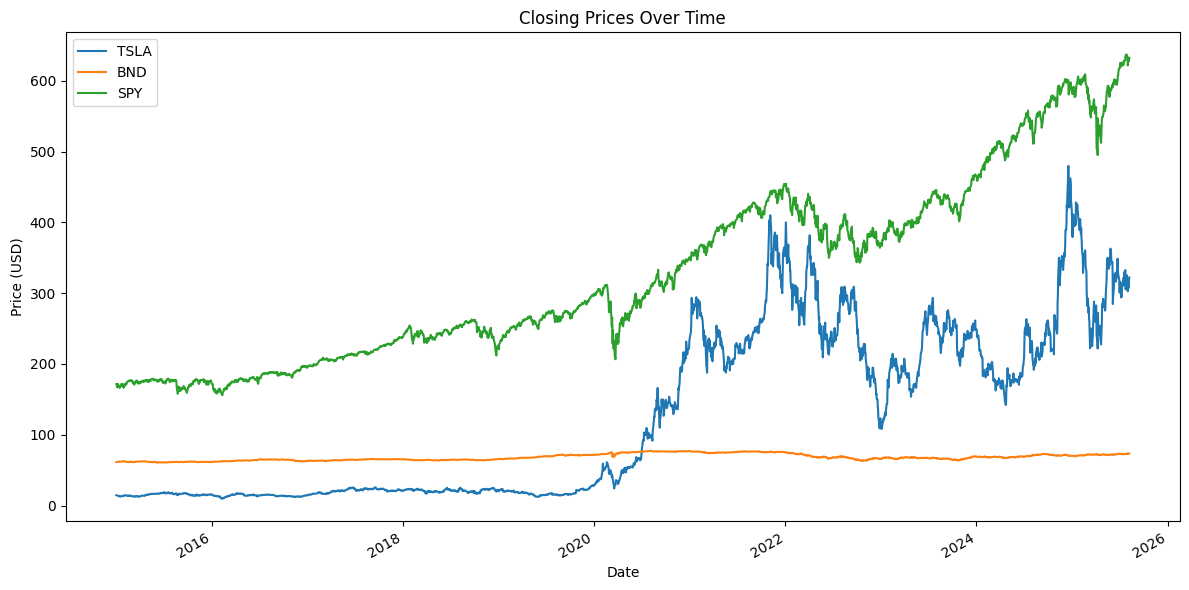

In [3]:
# Plot closing prices
close.plot(figsize=(12,6))
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

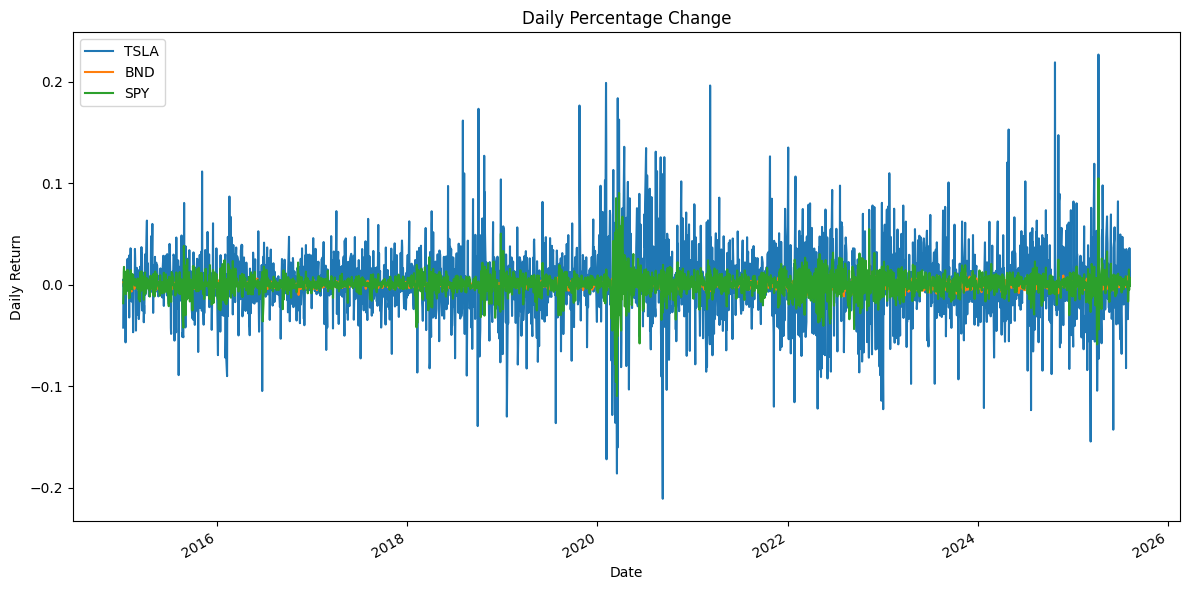

In [4]:
# Daily returns
returns = close.pct_change().dropna()
returns.plot(figsize=(12,6))
plt.title('Daily Percentage Change')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.tight_layout()
plt.show()

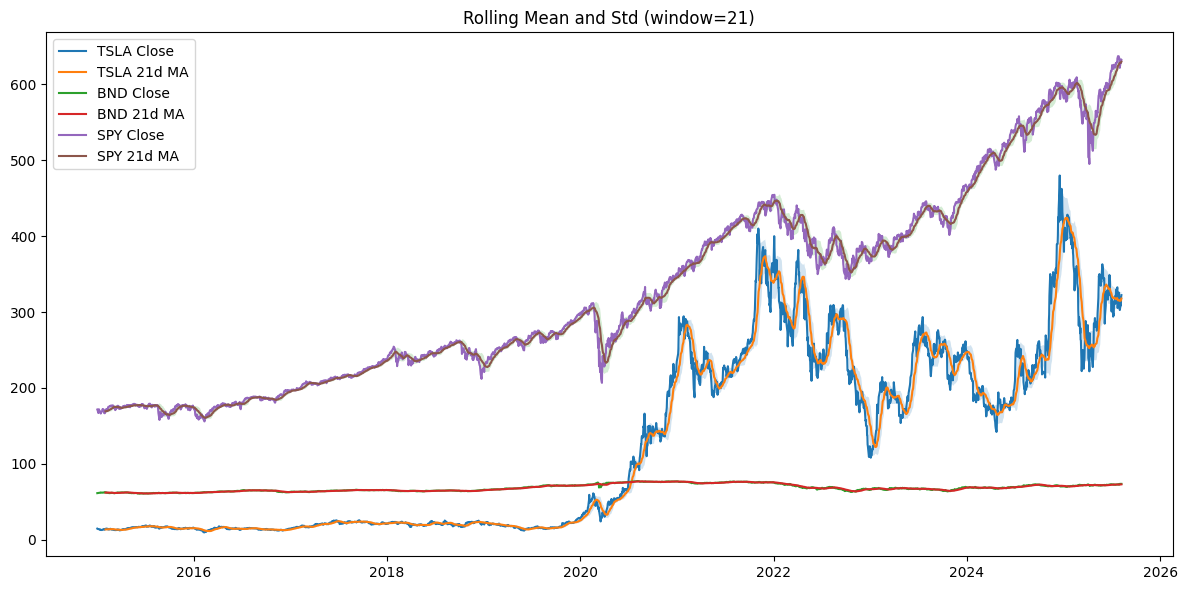

In [5]:
# Rolling mean and std
window = 21
rolling_mean = close.rolling(window).mean()
rolling_std = close.rolling(window).std()
plt.figure(figsize=(12,6))
for ticker in close.columns:
    plt.plot(close[ticker], label=f'{ticker} Close')
    plt.plot(rolling_mean[ticker], label=f'{ticker} {window}d MA')
    plt.fill_between(rolling_std.index, rolling_mean[ticker]-rolling_std[ticker], rolling_mean[ticker]+rolling_std[ticker], alpha=0.2)
plt.title(f'Rolling Mean and Std (window={window})')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Outlier detection
z_scores = (returns - returns.mean())/returns.std()
outliers = (np.abs(z_scores) > 3)
print('Outlier days:')
display(returns[outliers.any(axis=1)])

Outlier days:


,TSLA,BND,SPY
Date,,,
2015-08-24,-0.051567,-0.000243,-0.042107
2015-08-26,0.021861,-0.004281,0.038394
2016-06-24,-0.016548,0.005647,-0.035909
2018-02-05,-0.030895,0.004380,-0.041823
2018-02-08,-0.086290,-0.000752,-0.037509
...,...,...,...
2025-04-04,-0.104198,0.000813,-0.058543
2025-04-07,-0.025644,-0.012056,-0.001781
2025-04-09,0.226900,0.002345,0.105019


In [7]:
# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series.dropna())
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}
for ticker in close.columns:
    print(f'ADF Test for {ticker} Close:')
    print(adf_test(close[ticker]))
    print(f'ADF Test for {ticker} Returns:')
    print(adf_test(returns[ticker]))

ADF Test for TSLA Close:
{'ADF Statistic': np.float64(-1.3034642080792274), 'p-value': np.float64(0.6275859477006243), 'Critical Values': {'1%': np.float64(-3.4328331864239274), '5%': np.float64(-2.8626370834536976), '10%': np.float64(-2.56735401579277)}}
ADF Test for TSLA Returns:
{'ADF Statistic': np.float64(-11.883119143574156), 'p-value': np.float64(6.111391423713291e-22), 'Critical Values': {'1%': np.float64(-3.4328247287969065), '5%': np.float64(-2.8626333483854043), '10%': np.float64(-2.5673520272226016)}}
ADF Test for BND Close:
{'ADF Statistic': np.float64(-1.2508534415061738), 'p-value': np.float64(0.6513465531128549), 'Critical Values': {'1%': np.float64(-3.4328191223134246), '5%': np.float64(-2.862630872437016), '10%': np.float64(-2.567350709015523)}}
ADF Test for BND Returns:
{'ADF Statistic': np.float64(-10.190405512775085), 'p-value': np.float64(6.3442869622885395e-18), 'Critical Values': {'1%': np.float64(-3.4328294203524243), '5%': np.float64(-2.8626354202775866), '10%

In [8]:
# Value at Risk (VaR) and Sharpe Ratio
def value_at_risk(returns, confidence=0.05):
    return returns.quantile(confidence)
def sharpe_ratio(returns, risk_free_rate=0.0):
    return (returns.mean() - risk_free_rate) / returns.std()
for ticker in returns.columns:
    print(f'Value at Risk (5%) for {ticker}: {value_at_risk(returns[ticker])}')
    print(f'Sharpe Ratio for {ticker}: {sharpe_ratio(returns[ticker])}')

Value at Risk (5%) for TSLA: -0.053295495229245884
Sharpe Ratio for TSLA: 0.04993723161576971
Value at Risk (5%) for BND: -0.004823105256147498
Sharpe Ratio for BND: 0.021613669044775644
Value at Risk (5%) for SPY: -0.01690492533421926
Sharpe Ratio for SPY: 0.04887911914973538
